In [1]:
Load_Data = False
dir_train_label ='Data/musicnet/train_labels'
dir_train_wav = 'Data/musicnet/train_data'
dir_test_label ='Data/musicnet/test_labels'
dir_test_wav = 'Data/musicnet/test_data'

https://www.kaggle.com/imsparsh/musicnet-dataset?select=musicnet

# MusicNet Dataset
## A curated collection of labeled classical music

### Context
MusicNet is a collection of 330 freely-licensed classical music recordings, together with over 1 million annotated labels indicating the precise time of each note in every recording, the instrument that plays each note, and the note's position in the metrical structure of the composition. The labels are acquired from musical scores aligned to recordings by dynamic time warping. The labels are verified by trained musicians; a labeling error rate of 4% has been estimated. The MusicNet labels are offered to the machine learning and music communities as a resource for training models and a common benchmark for comparing results.

Specifically, MusicNet labels is proposed as a tool to address the following tasks:
- Identify the notes performed at specific times in a recording.
- Classify the instruments that perform in a recording.
- Classify the composer of a recording.
- Identify precise onset times of the notes in a recording.
- Predict the next note in a recording, conditioned on history.

### Content
(Raw - recommended) The raw data is available in standard wav audio format, with corresponding label files in csv format. These data and label filenames are MusicNet ids, which you can use to cross-index the data, labels, and metadata files.

(Python) The Python version of the dataset is distributed as a NumPy npz file. This is a binary format specific to Python (WARNING: if you attempt to read this data in Python 3, you need to set encoding='latin1' when you call np.load or your process will hang without any informative error messages). This format has three dependencies:

Python - This version of MusicNet is distributed as a Python object.
NumPy - The MusicNet features are stored in NumPy arrays.
intervaltree - The MusicNet labels are stored in an IntervalTree.

### Acknowledgements
The MusicNet labels apply exclusively to Creative Commons and Public Domain recordings, and as such we can distribute and re-distribute the MusicNet labels together with their corresponding recordings. The music that underlies MusicNet is sourced from the Isabella Stewart Gardner Museum, the European Archive, and Musopen.

This work was supported by the Washington Research Foundation Fund for Innovation in Data-Intensive Discovery, and the program "Learning in Machines and Brains" (CIFAR).


# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from mido import MidiFile
import pygame
import IPython
import librosa.display
import keras.layers as L
import keras.models as M
import keras
from keras.layers import SimpleRNN,LSTM,GRU
from sklearn.model_selection import train_test_split
from IPython import *
from music21 import *
import os
import tensorflow as tf
from scipy.io import wavfile
from IPython.display import clear_output
from ast import literal_eval

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
Dir_midis = "Data/_midis"
Dir_train = "Data/musicnet"
Dir_meta = "Data/_metadata.csv"

In [ ]:
MetaData = pd.read_csv(Dir_meta)
mid = MidiFile(Dir_midis + '/musicnet_midis/Beethoven/2313_qt15_1.mid',clip=True)

In [ ]:
for i in mid.tracks[1]:
    print(i)

In [ ]:
note_on=[]
n=50
for m in range(n):
    mid=MidiFile(Dir_midis + '/musicnet_midis/Beethoven/'+os.listdir(Dir_midis + '/musicnet_midis/Beethoven')[m],clip=True)
    for j in range(len(mid.tracks)):
        for i in mid.tracks[j] :
            if str(type(i))!="<class 'mido.midifiles.meta.MetaMessage'>" :
                x=str(i).split(' ')
                if x[0]=='note_on':
                    note_on.append(int(x[2].split('=')[1]))

In [ ]:
import time
from IPython.display import clear_output
def live_plot_make(x,range_=20,pause_time=0.01,skip_a_do=1):
    for i in range(0,len(x)-range_,skip_a_do):
        plt.figure(figsize=(18,8))
        x_plot=x[i:i+range_]
        y_plot=[i for i in range(range_)]
        fig=plt.plot(y_plot,x_plot,marker='D')
        plt.ylim([min(x),max(x)])
        time.sleep(pause_time)
        clear_output(wait=True)
        plt.show()

In [ ]:
live_plot_make(note_on,range_=100,pause_time=0.02,skip_a_do=1000)

In [ ]:
for directory in os.listdir(Dir_midis + "/musicnet_midis/"):
    for filename in os.listdir(os.path.join(Dir_midis + "/musicnet_midis/", directory)):
        if filename.endswith(".mid"): 
            print(os.path.join(directory, filename))
            continue
        else:
            continue

# Load the Data
## Training Data

In [3]:
if(not Load_Data):
    train_label_data = pd.DataFrame()

    for filename in os.listdir(dir_train_label):
        label_data = pd.read_csv(os.path.join(dir_train_label,filename))
        label_data["ID"] = filename.split('.csv')[0]
        train_label_data = train_label_data.append(label_data)
else:
    train_label_data = pd.read_csv('train_label_data.csv')
train_label_data.head()

,start_time,end_time,instrument,note,start_beat,end_beat,note_value,ID
0,9182,90078,43,53,4.0,1.5,Dotted Quarter,1727
1,9182,33758,42,65,4.0,0.5,Eighth,1727
2,9182,62430,1,69,4.0,1.0,Quarter,1727
3,9182,202206,44,41,4.0,3.5,Whole,1727
4,9182,62430,1,81,4.0,1.0,Quarter,1727


In [4]:
if(not Load_Data):
    train_wav_data = pd.DataFrame()

    length = len(os.listdir(dir_train_wav))
    i = 0

    datapoint = []

    for filename in os.listdir(dir_train_wav):
        if filename.endswith(".wav"): 
            samplerate, data = wavfile.read(os.path.join(dir_train_wav,filename))
            datapoint.append([filename.split('.wav')[0], samplerate, data])
            i = i+1
            clear_output(wait=False)
            print((i/length)*100)
        
    train_wav_data = pd.DataFrame(datapoint, columns=['ID', 'SampleRate', 'WavData'])
else:
    train_wav_data = pd.read_csv('train_wav_data.csv')
    f = lambda x: np.array(x['WavData'][1:-1].split(' '))
    train_wav_data['WavData'] = train_wav_data.apply(f, axis=1)
    
train_wav_data.head()

100.0


,ID,SampleRate,WavData
0,1727,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1728,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1729,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1730,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1733,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


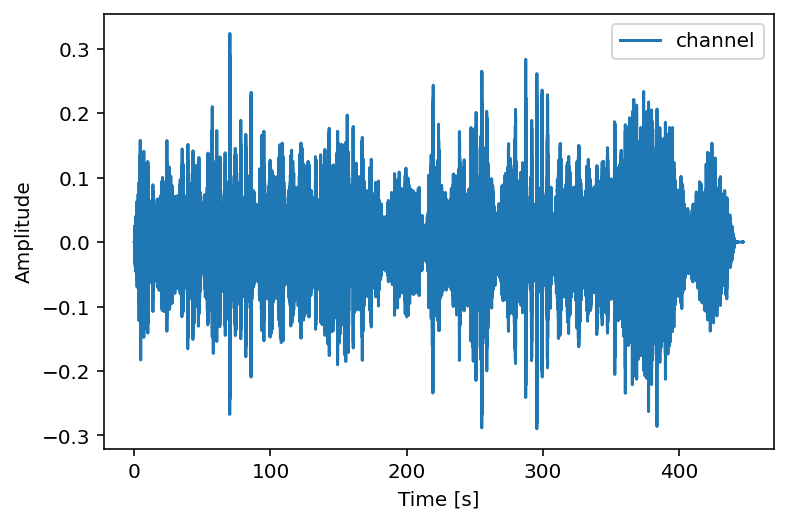

In [5]:
length = train_wav_data['WavData'][0].shape[0] / train_wav_data['SampleRate'][0]
time = np.linspace(0., length, train_wav_data['WavData'][0].shape[0])
data = train_wav_data['WavData'][0]
plt.plot(time, data[:], label="channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


## Testing Data

In [6]:
if(not Load_Data):
    test_label_data = pd.DataFrame()

    for filename in os.listdir(dir_test_label):
        label_data = pd.read_csv(os.path.join(dir_test_label,filename))
        label_data["ID"] = filename.split('.csv')[0]
        test_label_data = test_label_data.append(label_data)
else:
    test_label_data = pd.read_csv('test_label_data.csv')
test_label_data.head()

,start_time,end_time,instrument,note,start_beat,end_beat,note_value,ID
0,90078,124382,1,63,0.0,1.000,Quarter,1759
1,90078,124382,1,75,0.0,1.000,Quarter,1759
2,90078,110558,1,48,0.0,0.375,Dotted Sixteenth,1759
3,114654,122334,1,55,0.5,0.375,Dotted Sixteenth,1759
4,124382,139742,1,65,1.0,1.000,Quarter,1759


In [7]:
if(not Load_Data):
    test_wav_data = pd.DataFrame()

    length = len(os.listdir(dir_test_wav))
    i = 0

    datapoint = []

    for filename in os.listdir(dir_test_wav):
        if filename.endswith(".wav"): 
            samplerate, data = wavfile.read(os.path.join(dir_test_wav,filename))
            datapoint.append([filename.split('.wav')[0], samplerate, data])
            i = i+1
            clear_output(wait=False)
            print((i/length)*100)
        
    test_wav_data = pd.DataFrame(datapoint, columns=['ID', 'SampleRate', 'WavData'])
else:
    test_wav_data = pd.read_csv('test_wav_data.csv')
test_wav_data.head()

100.0


,ID,SampleRate,WavData
0,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1819,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2106,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2191,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2298,44100,"[0.0, -3.0517578e-05, 0.0, 0.0, 0.0, 0.0, 0.0,..."


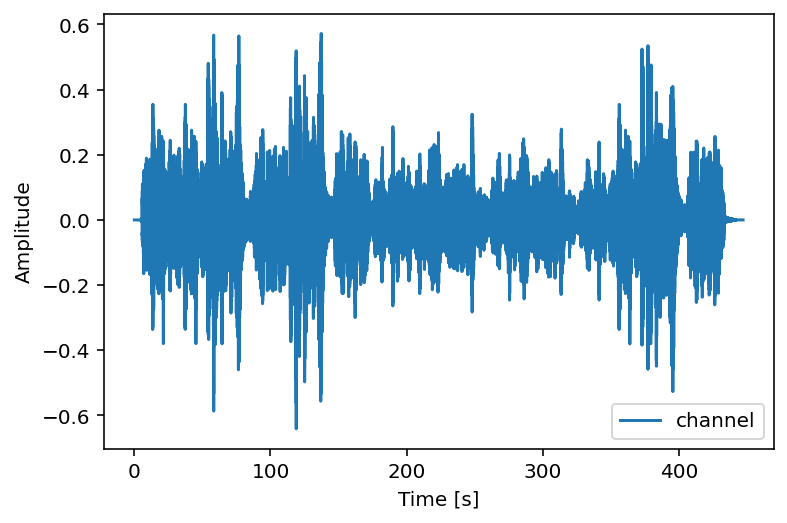

In [8]:
length = train_wav_data['WavData'][0].shape[0] / test_wav_data['SampleRate'][0]
time = np.linspace(0., length, test_wav_data['WavData'][0].shape[0])
data = test_wav_data['WavData'][0]
plt.plot(time, data[:], label="channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [13]:
train_data = train_label_data.merge(train_wav_data, left_on='ID', right_on='ID')
test_data = test_label_data.merge(test_wav_data, left_on='ID', right_on='ID')
train_data.head()

,start_time,end_time,instrument,note,start_beat,end_beat,note_value,ID,SampleRate,WavData
0,90078,124382,1,63,0.0,1.000,Quarter,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,90078,124382,1,75,0.0,1.000,Quarter,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,90078,110558,1,48,0.0,0.375,Dotted Sixteenth,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,114654,122334,1,55,0.5,0.375,Dotted Sixteenth,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,124382,139742,1,65,1.0,1.000,Quarter,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [14]:
test_data.head()

,start_time,end_time,instrument,note,start_beat,end_beat,note_value,ID,SampleRate,WavData
0,90078,124382,1,63,0.0,1.000,Quarter,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,90078,124382,1,75,0.0,1.000,Quarter,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,90078,110558,1,48,0.0,0.375,Dotted Sixteenth,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,114654,122334,1,55,0.5,0.375,Dotted Sixteenth,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,124382,139742,1,65,1.0,1.000,Quarter,1759,44100,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Basic Exploratory Data Analysis (EDA)

In [15]:
print(train_data.shape)
print(test_data.shape)

(1075951, 10)
(13589, 10)


In [16]:
train_data.describe()

,start_time,end_time,instrument,note,start_beat,end_beat,SampleRate
count,1.075951e+06,1.075951e+06,1.075951e+06,1.075951e+06,1.075951e+06,1.075951e+06,1075951.0
mean,1.054879e+07,1.056450e+07,1.945954e+01,6.379247e+01,4.822084e+02,6.501505e-01,44100.0
std,7.716965e+06,7.717804e+06,2.295974e+01,1.267144e+01,4.425553e+02,8.403071e-01,0.0
min,0.000000e+00,4.780000e+02,1.000000e+00,2.100000e+01,0.000000e+00,8.333333e-03,44100.0
25%,4.460510e+06,4.475870e+06,1.000000e+00,5.500000e+01,1.689771e+02,2.406250e-01,44100.0
50%,9.028574e+06,9.043422e+06,1.000000e+00,6.400000e+01,3.666250e+02,4.895833e-01,44100.0
75%,1.497033e+07,1.498723e+07,4.100000e+01,7.300000e+01,6.663333e+02,8.750000e-01,44100.0
max,4.629245e+07,4.662627e+07,7.400000e+01,1.040000e+02,4.314000e+03,1.029792e+02,44100.0


## Missing values

In [18]:
train_null = train_data.isnull().sum().sort_values(ascending=False)
train_null = train_null[train_null>0]

test_null = test_data.isnull().sum().sort_values(ascending=False)
test_null = test_null[test_null>0]

missing_df = pd.concat([train_null, 
                        test_null, 
                        train_null/len(train_data), 
                        test_null/len(test_data), 
                        train_data[train_null.index].dtypes, 
                        test_data[test_null.index].dtypes], axis=1)

missing_df.rename({0: "train_null",
                   1: "test_null",
                   2: "train_null ratio",
                   3: "test_null ratio",
                   4: "dtype_train",
                   5: "dtype_test"}, axis='columns')

,train_null,test_null,train_null ratio,test_null ratio,dtype_train,dtype_test


### Doesn't seem to be any missing values so we can leave that here.

## Analyse target variable
We have a few target variables depending on what we are trying to find:
1) Identify the notes performed at specific times in a recording.

2) Classify the instruments that perform in a recording.

3) Classify the composer of a recording.

4) Identify precise onset times of the notes in a recording.

5) Predict the next note in a recording, conditioned on history.

Let's start with the first goal, identifying the notes performed at a specific time in a recording. For this I can see three variables that will be the most useful: ID, Note, Time

In [30]:
train_data[['ID','note','note_value','start_time', 'end_time', 'WavData']]

,ID,note,note_value,start_time,end_time,WavData
0,1727,53,Dotted Quarter,9182,90078,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1727,65,Eighth,9182,33758,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1727,69,Quarter,9182,62430,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1727,41,Whole,9182,202206,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1727,81,Quarter,9182,62430,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
1075946,2678,86,Sixteenth,20614622,20626398,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1075947,2678,84,Thirty Second,20620254,20626398,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1075948,2678,83,Quarter,20626910,20684254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1075949,2678,79,Quarter,20626910,20684766,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
